In [1]:
import torch
from tqdm.auto import tqdm
from optree import tree_map
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True, batch_size=32)
num_data = len(train_dataloader.dataset)
print("Training data size: ", num_data)

Training data size:  1000


In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data, prior_sd=1e3)

# Turn off Dropout
model.eval()

# Load to GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Only train the last layer
for name, param in model.named_parameters():
    if 'bert' in name:
        param.requires_grad = False

In [5]:
# Extract only the parameters to be trained
sub_params, sub_param_to_log_posterior = uqlib.extract_requires_grad_and_func(dict(model.named_parameters()), param_to_log_posterior)

In [6]:
# Store initial values of sub_params to check against later
init_sub_params = tree_map(lambda x: x.detach().clone(), sub_params)

In [7]:
# Train using SGHMC
# sghmc_transform = uqlib.sgmcmc.sghmc.build(sub_param_to_log_posterior, lr=1e-2, alpha=1e-6, temperature=1/num_data)
# momenta = tree_map(lambda x: torch.randn_like(x), sub_params)
momenta = None
lr = 1e-1
sghmc_transform = uqlib.sgmcmc.sghmc.build(sub_param_to_log_posterior, lr=lr, alpha=5., temperature=0., momenta=momenta)

num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)

progress_bar = tqdm(range(num_training_steps))

log_posts = []

state = sghmc_transform.init(sub_params)

# model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        state = sghmc_transform.update(state, batch)
        log_posts.append(state.log_posterior)
        print(log_posts[-1], end='\r')
        progress_bar.update(1)

  0%|          | 0/960 [00:00<?, ?it/s]

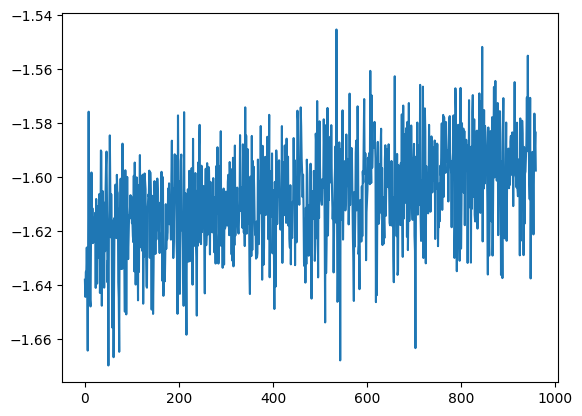

In [8]:
# Plot convergence
plt.plot(log_posts);

In [9]:
final_sub_params = state.params

init_sub_params_flat = torch.cat([v.flatten() for k, v in init_sub_params.items()])
final_sub_params_flat = torch.cat([v.detach().flatten() for k, v in final_sub_params.items()])

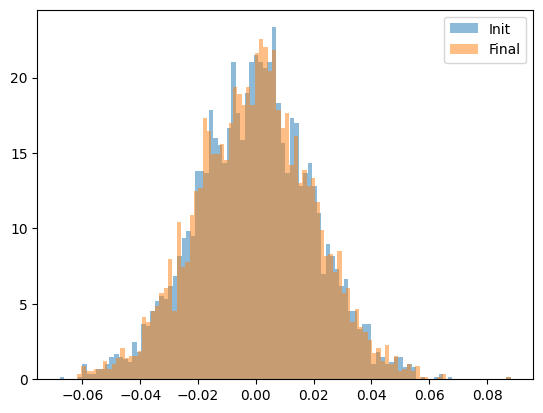

In [10]:
# Visualize trained sub_params vs their initial values
plt.hist(init_sub_params_flat.cpu().numpy(), bins=100, alpha=0.5, label='Init', density=True)
plt.hist(final_sub_params_flat.cpu().numpy(), bins=100, alpha=0.5, label='Final', density=True)
plt.legend();

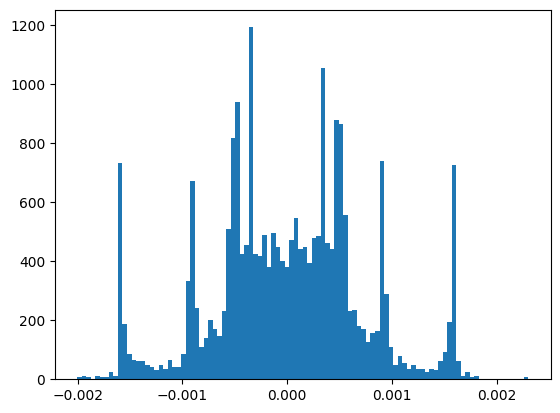

In [11]:
# Visualise momenta
momenta = tree_map(lambda x: x.detach().cpu().numpy(), state.momenta)
flat_momenta = torch.cat([torch.from_numpy(v.flatten()) for v in momenta.values()])
plt.hist(flat_momenta, bins=100, density=True);